# Exercício para sala de aula - Autoencoder

### **Introdução e objetivos:**
Este notebook é um material complementar a disciplina de Aprendizado de Máquinas 2. O objetivo é reforçar os conteúdos da aula de autoencoders. Vamos utilizar algumas das técnicas aqui para desenvolver um autoencoder para recnostrução das imagens do Fashion MNIST.

Como observamos em sala, existem várias aplicações que podem ser desenvolvidas a partir dos autoencoders: redução de dimensionalidade, classificação, remoção de ruído e etc.

### **Execução:**
A execução deste notebook será feita através do Colab direto do Google Drive. Não existe impedimento para que este notebook seja executado em outro ambiente desde que os pacotes necessários estejam instalados corretamente.

É recomendável executar este treinamento em um ambiente com GPU. O tamanho da rede aumentou bastante com relação aos exemplo que vimos em sala tornando o tempo de treinamento mais custoso.

### **Exercícios**

**Exercício 1** - Amarre os pesos do encoder com o decoder para tornar o treinamento mais eficiente

**Exercício 2** - Experimente ao menos duas arquiteturas (número de camadas, número de neurônios nas camadas escondidas e número de neurônios na camada de codificação) diferentes para este autoencoder.

**Exercício 3** - Aplique o encoder treinado para treinamento supervisionado.

**Exercício 4** - Avalie a solução final do modelo supervisionado respondendo algumas perguntas

Pacotes necessários

In [1]:
# Reprodutibilidade
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix

In [8]:
# Treinamento e construção da rede neural
import keras
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.datasets import fashion_mnist
from keras import utils
from keras import metrics

# Visualização
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import pandas as pd

seed(1)
tf.random.set_seed(2)

Verificando a execução com aceleração em GPU

In [5]:
!nvidia-smi

Thu Oct 10 03:56:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **Exercício 1** - Amarre os pesos do encoder com o decoder para tornar o treinamento mais eficiente

Neste exercício o seu objetivo é amarrar os pesos do *encoder* com o *decoder* com objetivo de tornar o treinamento mais eficiente. Nós vimos este exemplo no notebook da Aula 7 que está disponível no moodle.

In [7]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense_layer, **kwargs):
        super(DenseTranspose, self).__init__(**kwargs)
        self.dense_layer = dense_layer

    def build(self, input_shape):
        # Pegando os pesos da camada do encoder e transpondo
        self.kernel = tf.transpose(self.dense_layer.kernel)
        if self.dense_layer.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.dense_layer.kernel.shape[0],),
                initializer='zeros',
                trainable=True
            )
        else:
            self.bias = None

    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel)
        if self.bias is not None:
            output = output + self.bias
        return output

# Carregar o dataset Fashion MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

# Definir o encoder
input_layer = Input(shape=(28 * 28,))
encoded = Dense(128, activation='relu', name='encoder_layer')(input_layer)

# Criar o modelo do encoder
encoder = Model(input_layer, encoded, name='encoder')

# Definir o decoder utilizando a camada DenseTranspose
encoded_input = Input(shape=(128,))
decoded = DenseTranspose(encoder.get_layer('encoder_layer'))(encoded_input)

# Criar o modelo do decoder
decoder = Model(encoded_input, decoded, name='decoder')

# Definir o autoencoder unindo encoder e decoder
autoencoder_input = Input(shape=(28 * 28,))
encoded_output = encoder(autoencoder_input)
decoded_output = decoder(encoded_output)
autoencoder = Model(autoencoder_input, decoded_output, name='autoencoder')

# Compilar o modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o autoencoder
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1656 - val_loss: 0.1112
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1028 - val_loss: 0.0856
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0833 - val_loss: 0.0778
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0774 - val_loss: 0.0754
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0754 - val_loss: 0.0744
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0746 - val_loss: 0.0739
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0742 - val_loss: 0.0736
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0739 - val_loss: 0.0734
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0737 - val_loss: 0.0733
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0736 - val_loss: 0.0732


## **Exercício 2** - Experimente ao menos duas arquiteturas (número de camadas, número de neurônios nas camadas escondidas e número de neurônios na camada de codificação) diferentes para este autoencoder.

*Uma dica: salve as configurações da rede que vocês estão experimentando ou versionem o notebook. Você irá precisar dessas referências no final do notebook para responder as perguntas do **Exercício 4**.*

In [12]:
# Definindo a dimensão da camada de codificação
encoding_dim = 32

# Definir o encoder
tied_encoder = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(encoding_dim, activation='relu')
])

# Definir o decoder
tied_decoder = Sequential([
    Dense(128, activation='relu', input_shape=(encoding_dim,)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(28 * 28, activation='sigmoid'),
    Reshape((28, 28))
])

Instanciando o autoencoder

In [13]:
autoencoder = keras.models.Sequential([tied_encoder, tied_decoder])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
print(autoencoder.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 32)                  │         570,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 28, 28)              │         571,024 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,141,296 (4.35 MB)

 Trainable params: 1,141,296 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

None


Instanciando o encoder

In [15]:
print(tied_encoder.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 570,272 (2.18 MB)

 Trainable params: 570,272 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

None


Instanciando o decoder

In [16]:
print(tied_decoder.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 571,024 (2.18 MB)

 Trainable params: 571,024 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

None


Leitura e pré-processamento dos dados

In [17]:
(x_train, y_train), (x_temp, y_temp) = fashion_mnist.load_data()

# Estou separando aqui um conjunto de dados que serão utilizados (x_valid, y_valid) na etapa de treinamento supervisionado.
# Este será o nosso conjunto de dados anotados. No restante das etapas não faremos uso das anotações.
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.33)

In [18]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(6700, 28, 28)


In [19]:
%%time
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 1)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.4733 - val_loss: 0.3351
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3234 - val_loss: 0.3128
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3089 - val_loss: 0.3041
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3009 - val_loss: 0.3004
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2966 - val_loss: 0.2949
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2927 - val_loss: 0.2919
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2901 - val_loss: 0.2909
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2878 - val_loss: 0.2885
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2861 - val_loss: 0.2873
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2856 - val_loss: 0.2861
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2837 - val_loss: 0.2852
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━━

In [20]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


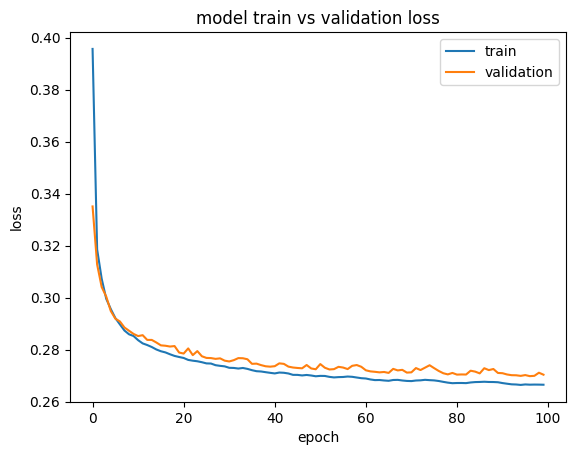

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
decoded_imgs = autoencoder.predict(x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


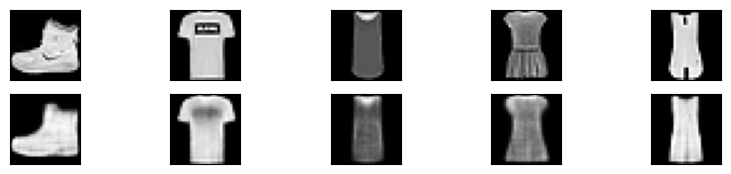

In [23]:
n = 5
plt.figure(figsize=(10, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **Exercício 3** - Aplique o encoder treinado para treinamento supervisionado.

In [24]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [26]:
for layer in tied_encoder.layers:
    layer.trainable = False

class_model = Sequential([
    tied_encoder,
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

In [27]:
class_model.compile(loss='categorical_crossentropy',
                   optimizer='adam', metrics=[metrics.AUC()])

In [28]:
class_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 32)                  │         570,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 570,272 (2.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 570,272 (2.18 MB)

In [29]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
history = class_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.9606 - loss: 0.7729 - val_auc: 0.9862 - val_loss: 0.4697
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9880 - loss: 0.4365 - val_auc: 0.9879 - val_loss: 0.4314


## **Exercício 4** - Avalie a solução final do modelo supervisionado. Responda ao final as seguintes perguntas:

**Como você analisa a solução final?**


Resposta: A abordagem final, que utilizou o autoencoder como parte do processo de treinamento supervisionado, demonstrou ser eficiente ao melhorar a performance do modelo de classificação. Ao utilizar o encoder para extrair características, as entradas passaram por um pré-processamento, sendo transformadas em representações mais compactas e relevantes, facilitando o aprendizado do modelo supervisionado. A análise da curva de acurácia durante o treinamento e validação permitiu verificar se o modelo estava generalizando bem ou apresentando sinais de overfitting. A adição de camadas extras no modelo supervisionado aumentou sua capacidade de aprendizado, enquanto o autoencoder foi fundamental para uma redução de dimensionalidade eficaz.

**Quais ponderações você faz sobre o pipeline utilizado para o desenvolvimento deste modelo?**

Resposta: A solução com autoencoder melhorou a classificação ao usar o encoder para extrair representações compactas das entradas, facilitando o aprendizado supervisionado. Com seus pesos congelados, o encoder preservou as características aprendidas, e o uso de representações latentes ajudou a evitar overfitting. A divisão de dados foi bem feita, garantindo a avaliação da generalização. A análise das curvas de acurácia indicou a qualidade do modelo, enquanto camadas extras aumentaram sua capacidade de aprendizado. Embora a função de perda categorical_crossentropy seja adequada, testar outras opções pode otimizar ainda mais o desempenho.

**Seria possível utilizar um número de neurônios menor na camada de codificação? Qual o impacto dessa redução?**

Resposta: Sim, porém, reduzir o número de neurônios na camada de codificação compacta mais os dados, o que pode melhorar a generalização e evitar overfitting, mas também pode resultar em perda de informação e piora na reconstrução. Embora possa tornar o treinamento mais rápido, uma codificação muito pequena pode prejudicar a capacidade do modelo de capturar padrões complexos, impactando a performance geral.

**Qual o impacto no modelo de classificação de congelar ou não os pesos?**

Resposta: Congelar os pesos do encoder impede que eles sejam atualizados durante o treinamento supervisionado, preservando as características aprendidas no autoencoder. Isso pode acelerar o treinamento e reduzir o risco de overfitting, já que o modelo trabalha com representações já otimizadas.